In [108]:
import numpy as np
import scipy as sp
from scipy import optimize as op
from scipy import linalg
import math
from copy import deepcopy
import matplotlib.pyplot as plt
# from sympy import symbols, Matrix # not used???

In [ ]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html

In [220]:
class Solution:
    def __init__(self, m, c, b, eps=1e-3, 
    real_start=-10, real_end=10, 
    imag_start=-10, imag_end=10):
        self.b_ = b / m
        self.c_ = c / m
        self.roots = None
        self.order = 5
        self.eps = eps

        self.real_start = real_start
        self.real_end = real_end
        self.imag_start = imag_start
        self.imag_end = imag_end

        self.A = np.eye(4, dtype=np.complex)
        self.B = np.zeros((4, 4), dtype=np.complex); self.B[0, 0] = self.b_
        self.C = np.array([
            [2, -1, 0, -1],
            [-1, 2, -1, 0],
            [0, -1, 2, -1],
            [-1, 0, -1, 2]
        ], dtype=np.complex) * self.c_


    def __call__(self, x):
        x = complex(x[0], x[1])
        result = self.b_ * (2 * self.c_ ** 2 + 4 * self.c_ * x ** 2 + x ** 4) +\
             8 * self.c_ ** 2 * x + 6 * self.c_ * x ** 3 + x ** 5
        return result.real, result.imag

    def __clear_roots(self):
        # I don't know better algorithm.
        # Just O(n^2)
        # faster will be find connectivity components!!!
        # distances = self.roots.reshape(-1, 1) - self.roots
        # equal = abs(distances) < self.eps

        self.roots = np.array(self.roots)

        use = np.ones_like(self.roots, dtype=np.bool)

        for i in range(len(self.roots)):
            if use[i] == False:
                continue
            for j in range(len(self.roots)):
                if i == j:
                    continue
                if abs(self.roots[i] - self.roots[j]) < self.eps:
                    use[j] = False

        self.roots = self.roots[use]


    def find_roots(self):
        if self.roots is None:
            self.roots = []
        else:
            return deepcopy(self.roots)

        real = range(self.real_start, self.real_end, 1)
        imag = range(self.imag_start, self.imag_end, 1)

        for r in real:
            for im in imag:
                root = op.root(self, [r, im])
                self.roots.append(complex(*root.x))
        self.__clear_roots()

        # can find theoretically
        self.roots = np.append(self.roots, (
            0, 
            complex(0, self.c_ * np.sqrt(2)), 
            complex(0, -self.c_ * np.sqrt(2)))
        )

        return deepcopy(self.roots)

    def get_eigen_vectors(self, lambd, rcond=1e-3):
        charact_matr = self.A * lambd ** 2 + self.B * lambd + self.C
        eigenvector = linalg.null_space(charact_matr, rcond=rcond)
        return eigenvector

    def find_eigen_vectors(self):
        self.vectors = []
        for lambd in self.roots:
            vec = self.get_eigen_vectors(lambd).squeeze()
            self.vectors.append(vec)
        self.vectors = np.array(self.vectors)

    def find_solution_coeffs(self, q_0):
        # now I have equation
        # q(t) = c_1 h_1 exp(lambda_1 * t) + ... + c_8 h_8 exp(lambda_8 * t)
        # and I should find the c_1, ..., c_8
        # I suppose that q_i = 0 forall i

        self.find_eigen_vectors()

        # find the equation matrix
        first_part = deepcopy(self.vectors).T
        second_part = self.roots * first_part
        eq_matr = np.vstack((first_part, second_part))

        # find q_0
        q_0 = np.array(q_0).reshape(-1, 1)
        q_0 = np.vstack((q_0, np.zeros((first_part.shape[0], 1))))

        # find constants
        self.constants = linalg.solve(eq_matr, q_0)

    def solve(self, *args, **kwargs):
        self.find_roots()
        self.find_solution_coeffs(*args, **kwargs)
    
    def q(self, t, eps=1e-3):
        coords_ = np.zeros(4, dtype=complex)
        for i in range(len(self.roots)):
            coords_ += self.constants[i] * self.vectors[i] * np.exp(t * self.roots[i])
        return coords_

# eq = Solution(1, 1, 1)
# eq.find_roots()

# for root in eq.find_roots():
    # print(root)
    # print(eq.get_eigen_vectors(root))

# eq.find_solution_coeffs((1, 0, -1, 0))
# eq.q(1)

In [228]:
eq = Solution(1, 1, 1)
eq.solve((1, 0, -1, 0))

times = np.linspace(0, 10, 100)
coords = []
for t in times:
    coords.append(eq.q(t))

coords = np.array(coords)

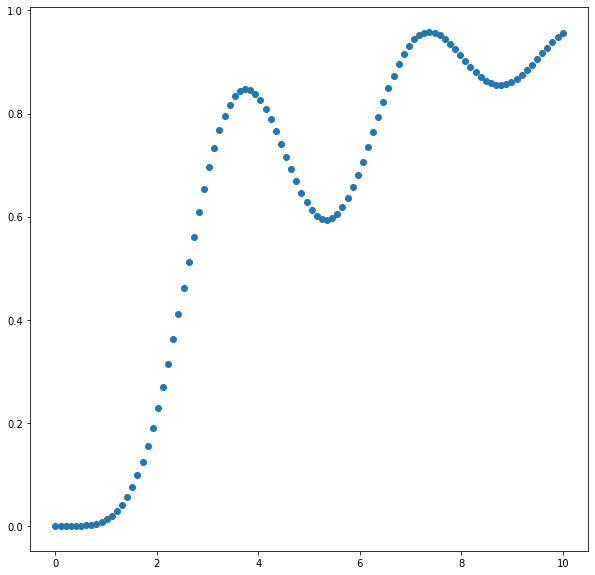

In [233]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)

plt.scatter(times, np.real(coords[:, 3]))

It is integesting to observe how roots depend on $\beta$. And I also suppose that $\widehat{c} = 1$.

In [214]:
# with plt.style.context('seaborn-darkgrid'):?
m = 1
c = 1

roots = []

for beta in np.linspace(0, 5, 15):
    eq = Solution(m, beta, c)
    curr_roots = eq.find_roots()
    for root in curr_roots:
        roots.append((beta, root))

roots = np.array(roots)

/usr/lib/python3/dist-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


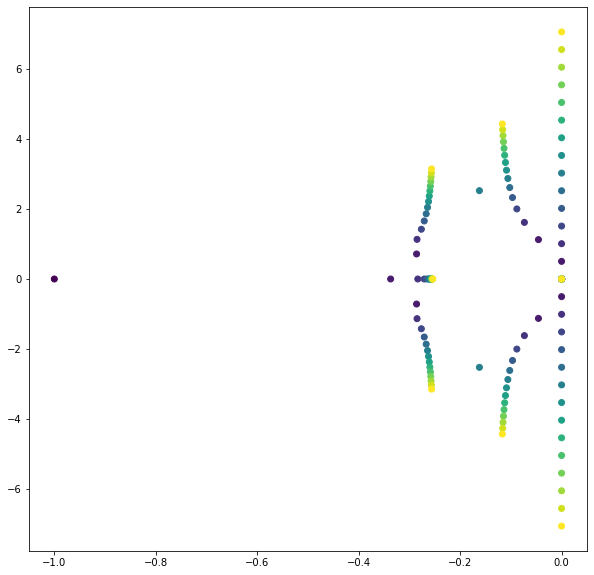

In [215]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
ax.scatter(np.real(roots[:, 1]), np.imag(roots[:, 1]), c=(roots[:, 0] + 1))